In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import csv
import string
import re
import os
import json
import datetime
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#remove stopwords
import stop_words
from stop_words import get_stop_words
stop_words = get_stop_words('en')

# LSTM

In [2]:
from LSTM_predict import LSTModel
# open ground truth df
ground_truth_data = pd.read_csv('ground_truth_datasets\LSTM_all_groundtruth.csv') 
# making predictions
file_model = 'Model Selection\Models\LSTM\LSTM_model_glove.json'
file_weights = 'Model Selection\Models\LSTM\LSTM_model_glove.h5'
file_tokenizer = 'Model Selection\Models\LSTM\LSTM_tokenizer_def.pickle'
model = LSTModel(file_model, file_weights, file_tokenizer)
pred_prob = model.predict_prob(ground_truth_data['text'].astype(str))
pred_label = model.predict_class(ground_truth_data['text'].astype(str)) 
# building df with author, post and predictions
true_label = ground_truth_data['label'] 
pred_prob = pred_prob.T
pred_label = pred_label.T
ground_truth_data['pred_prob'] = pred_prob[0]
ground_truth_data['pred_label'] = pred_label[0]
ground_truth_data['true_label'] = true_label

Using TensorFlow backend.


In [3]:
ground_truth_data.to_csv('ground_truth_datasets\LSTM_all_groundtruth_pred.csv')

In [4]:
# selecting polarized and active ground truth users to perform validation on less polarized topics
# all users df
authors_list =  ground_truth_data.groupby('author')['pred_prob'].count().index.get_level_values(0).tolist()
count_authors = ground_truth_data.groupby('author')['pred_prob'].count().tolist()
mean_score_authors = ground_truth_data.groupby('author')['pred_prob'].mean().tolist()
df_authors_score = pd.DataFrame(
    {'author': authors_list,
     'author_count': count_authors,
     'mean_score': mean_score_authors,
    })
df_authors_score = df_authors_score.sort_values(by=['author_count'], ascending=False)
print('# all authors:', len(df_authors_score))
# active users (i.e., users with two or more posts shared)
author_cnt = dict()
for i in range(0, len(authors_list)):
    author_cnt[authors_list[i]] = count_authors[i]
author_cnt_2 = dict()
for author in author_cnt:
    if author_cnt[author] !=1:
        author_cnt_2[author] = author_cnt[author]
df_authors_score = df_authors_score.loc[df_authors_score.author.isin(list(author_cnt_2.keys()))]
authors_list = df_authors_score['author'].to_list()
mean_score_authors = df_authors_score['mean_score'].to_list()
print('# active users:', len(df_authors_score))
# polarized users (i.e., users with a prediction score >= 0.7 or <= 0.3)
user_polscore = list()
for score in mean_score_authors:
    if score <= 0.3:
        user_polscore.append(0)
    elif score >= 0.7:
        user_polscore.append(1)
    else:
        user_polscore.append('neu')
author_leaning = dict()
for i in range(0, len(authors_list)):
    author_leaning[authors_list[i]] = user_polscore[i]
author_leaning2 = dict()
for author in author_leaning.keys():
    if author_leaning[author] != 'neu':
        author_leaning2[author] = author_leaning[author]
print('# polarized users:', len(list(author_leaning2.keys())))
with open('ground_truth_datasets\LSTM_authors_leaning.pickle', "wb") as output_file:
        pickle.dump(author_leaning2, output_file)

# all authors: 42206
# active users: 19639
# polarized users: 13043


# BERT

In [5]:
# ground truth df
ground_truth_data = pd.read_csv('ground_truth_datasets\BERT_all_groundtruth.csv')
# making predictions
with open('Model Evaluation\groundtruth_predictions_val.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions[0]
true_label = predictions[1]
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
ground_truth_data['pred_prob'] = prob_pred
ground_truth_data['pred_label'] = pred_label
ground_truth_data['true_label'] = true_label
ground_truth_data.to_csv('ground_truth_datasets\BERT_all_groundtruth_pred.csv')

In [6]:
print('# ground truth user')
len(ground_truth_data['author'].unique())

# ground truth user


42206

In [7]:
# selecting polarized and active ground truth users to perform validation on less polarized topics
# all users df
authors_list =  ground_truth_data.groupby('author')['pred_prob'].count().index.get_level_values(0).tolist()
count_authors = ground_truth_data.groupby('author')['pred_prob'].count().tolist()
mean_score_authors = ground_truth_data.groupby('author')['pred_prob'].mean().tolist()
df_authors_score = pd.DataFrame(
    {'author': authors_list,
     'author_count': count_authors,
     'mean_score': mean_score_authors,
    })
df_authors_score = df_authors_score.sort_values(by=['author_count'], ascending=False)
print('# all authors:', len(df_authors_score))
# active users (i.e., users with two or more posts shared)
author_cnt = dict()
for i in range(0, len(authors_list)):
    author_cnt[authors_list[i]] = count_authors[i]
author_cnt_2 = dict()
for author in author_cnt:
    if author_cnt[author] !=1:
        author_cnt_2[author] = author_cnt[author]
df_authors_score = df_authors_score.loc[df_authors_score.author.isin(list(author_cnt_2.keys()))]
authors_list = df_authors_score['author'].to_list()
mean_score_authors = df_authors_score['mean_score'].to_list()
print('# active users:', len(df_authors_score))
# polarized users (i.e., users with a prediction score >= 0.7 or <= 0.3)
user_polscore = list()
for score in mean_score_authors:
    if score <= 0.3:
        user_polscore.append(0)
    elif score >= 0.7:
        user_polscore.append(1)
    else:
        user_polscore.append('neu')
author_leaning = dict()
for i in range(0, len(authors_list)):
    author_leaning[authors_list[i]] = user_polscore[i]
author_leaning2 = dict()
for author in author_leaning.keys():
    if author_leaning[author] != 'neu':
        author_leaning2[author] = author_leaning[author]
print('# polarized users:', len(list(author_leaning2.keys())))
with open('ground_truth_datasets\BERT_authors_leaning.pickle', "wb") as output_file:
        pickle.dump(author_leaning2, output_file)

# all authors: 42206
# active users: 19639
# polarized users: 15663


# Model Validation on less polarized topics

In [8]:
# dict of users, polarization score for validation (i.e., we search post written by these users in others subreddit)
with open('ground_truth_datasets\BERT_authors_leaning.pickle", "rb") as input_file: # BERT ground truth authors and leaning
    BERT_authors_leaning = pickle.load(input_file)  
with open('ground_truth_datasets\LSTM_authors_leaning.pickle", "rb") as input_file: # LSTM ground truth authors and leaning
    LSTM_authors_leaning = pickle.load(input_file) 

In [9]:
len(LSTM_authors_leaning)

13043

In [10]:
#  Removing Contractions not present in Word Embeddings mapping
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
    
def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

In [11]:
def DataCleaning(submissions, classifier):
    '''
    Clean raw post/comment text with standard preprocessing pipeline
    '''
    # Lowercasing text
    submissions = [elem.lower() for elem in submissions] 
    # Removing not printable characters 
    submissions = [''.join(filter(lambda x:x in string.printable, text)) for text in submissions]
    # Removing XSLT tags
    submissions = [re.sub(r'&lt;/?[a-z]+&gt;', '', text) for text in submissions]
    submissions = [text.replace(r'&amp;', 'and') for text in submissions]
    submissions = [text.replace(r'&gt;', '') for text in submissions]
    # Removing newline, tabs and special reddit words
    submissions = [text.replace('\n',' ') for text in submissions]
    submissions = [text.replace('\t',' ') for text in submissions]
    submissions = [text.replace('[deleted]','').replace('[removed]','') for text in submissions]
    # Removing HTTTP/HTTPS URL
    submissions = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) for text in submissions]
    # Removing numbers
    submissions = [re.sub(r'\w*\d+\w*', '', text) for text in submissions]
    if classifier == 'LSTM':
        # Removing contractions
        submissions = [replace_contractions(text) for text in submissions]
        # Removing Punctuation
        submissions = [text.translate(str.maketrans('', '', string.punctuation)) for text in submissions]
        # Removing stop words
        submissions = [remove_stopWords(text) for text in submissions]
    # Removing extra spaces
    submissions = [re.sub(r'\s{2,}', " ", text) for text in submissions]
    return submissions
    

## Minority

In [12]:
with open('topic_data\minority_rawpost.pickle', "rb") as input_file:
     minority_all = pickle.load(input_file)
minority_all = minority_all.loc[minority_all.author != '[deleted]']
minority_all = minority_all.loc[minority_all.author != 'AutoModerator']
minority_all['clean_text'] = minority_all['title']+' '+minority_all['selftext']
submissions = minority_all.clean_text.values.tolist()
submissions = DataCleaning(submissions, 'BERT') # Data Cleaning changes if using BERT or LSTM Classifier
minority_all['clean_text'] = submissions
minority_all['post_id'] = 't3_'+minority_all['id'] # adding 't3_' symbol to retrieve post' comments (i.e., Reddit standard for post identification)
minority_all['date'] = pd.to_datetime(minority_all['created_utc'], unit='s') # transform unixtime stamp in a readable format
minority_all['date'] = minority_all['date'].dt.date
minority_all = minority_all.drop(['selftext', 'title', 'over_18', 'stickied'], axis=1)
minority_all.to_csv('topic_data\minority_cleanedpost.csv')
# selecting only post written by ground truth users to make validation
minority_val = minority_all.loc[minority_all.author.isin(list(BERT_authors_leaning.keys()))]
print('# validation post', len(minority_val))
minority_val['label'] = minority_val.apply(lambda row: BERT_authors_leaning[row.author], axis=1)
n_users = minority_val.groupby(['author']).count()
# stats
print('n_users', len(n_users))
print('# pro trump and anti trump posts')
print(minority_val['label'].value_counts())
#print(minority_val.groupby(['subreddit','label'])['label'].count())

# validation post 26187
n_users 1749
# pro trump and anti trump posts
1    16009
0    10178
Name: label, dtype: int64
ipykernel_launcher:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# balancing discrimination test set among the two class
minority_val_left = minority_val.loc[minority_val.label == 0]
minority_val_right = minority_val.loc[minority_val.label == 1].sample(11000)
minority_val = minority_val_left.append(minority_val_right, ignore_index=True)

### BERT

In [14]:
minority_val.to_csv('topic_data\minority_validation.csv')
with open('topic_data\minority_predictions_val.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions[0]
true_label = predictions[1]
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
# Confusion Matrix
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[7038 2551]
 [1897 3725]]
Accuracy Score : 0.7075800407599764
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76      9589
         1.0       0.59      0.66      0.63      5622

    accuracy                           0.71     15211
   macro avg       0.69      0.70      0.69     15211
weighted avg       0.72      0.71      0.71     15211



### LSTM

In [15]:
from LSTM_predict import LSTModel

file_model = 'Model Selection\Models\LSTM\LSTM_model_glove.json'
file_weights = 'Model Selection\Models\LSTM\LSTM_model_glove.h5'
file_tokenizer = 'Model Selection\Models\LSTM\LSTM_tokenizer_def.pickle'
model = LSTModel(file_model, file_weights, file_tokenizer)
pred_prob = model.predict_prob(minority_val['clean_text'])
pred_label = model.predict_class(minority_val['clean_text']) 
true_label = minority_val['label'] 
# computing performances
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[6673 3505]
 [3888 7112]]
Accuracy Score : 0.6509113230711115
Classification Report : 
              precision    recall  f1-score   support

           0       0.63      0.66      0.64     10178
           1       0.67      0.65      0.66     11000

    accuracy                           0.65     21178
   macro avg       0.65      0.65      0.65     21178
weighted avg       0.65      0.65      0.65     21178



### Predict political polarization degree of all Minority post

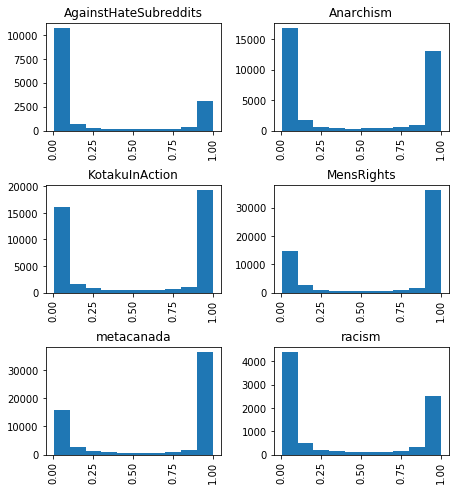

In [16]:
minority_all_post = pd.read_csv('topic_data\minority_cleanedpost.csv')
with open('topic_data\ALL_minority_predictions.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
minority_all_post['pred_label'] = pred_label
minority_all_post['pred_prob'] = prob_pred
minority_all_post.to_csv('topic_data\minority_cleanedpost_pred.csv', index=False)
minority_all_post['pred_prob'].hist(by=minority_all_post['subreddit'], figsize=(7,8))
plt.savefig('topic_data\graphs\minority_predxsubreddit.png')
plt.show()

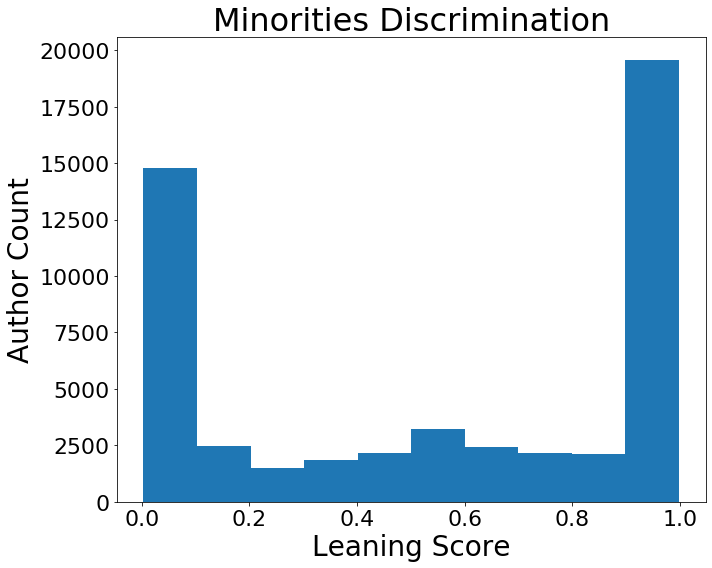

In [17]:
minority_user = pd.DataFrame({'prob_leaning' : minority_all_post.groupby( [ "author"] )['pred_prob'].mean()}).reset_index()
plt.figure(figsize=(10,8))
minority_user['prob_leaning'].hist(grid=False)
plt.xlabel('Leaning Score', size=28)
plt.ylabel('Author Count', size=28)
plt.title('Minorities Discrimination', size=32)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tight_layout()
plt.savefig('topic_data\graphs\minority_user_pred.png')

## Politics

In [22]:
with open('topic_data\politics_rawpost.pickle', "rb") as input_file:
     politics_all = pickle.load(input_file)
politics_all = politics_all.loc[politics_all.author != '[deleted]']
politics_all = politics_all.loc[politics_all.author != 'AutoModerator']
politics_all['clean_text'] = politics_all['title']+' '+politics_all['selftext']
submissions = politics_all.clean_text.values.tolist()
submissions = DataCleaning(submissions, 'BERT')
politics_all['clean_text'] = submissions
politics_all['clean_text'] = submissions
politics_all['clean_text'] = submissions
politics_all['post_id'] = 't3_'+politics_all['id'] # adding 't3_' symbol to retrieve post' comments (i.e., Reddit standard for post identification)
politics_all['date'] = pd.to_datetime(politics_all['created_utc'], unit='s') # transform unixtime stamp in a readable format
politics_all['date'] = politics_all['date'].dt.date
politics_all = politics_all.drop(['selftext', 'title', 'over_18', 'stickied'], axis=1)
politics_all.to_csv('topic_data\politics_cleanedpost.csv')

In [23]:
# selecting only post written by ground truth users to make validation
politics_val = politics_all.loc[politics_all.author.isin(list(BERT_authors_leaning.keys()))]
print('# validation post', len(politics_val))
politics_val['label'] = politics_val.apply(lambda row: BERT_authors_leaning[row.author], axis=1)
n_users = politics_val.groupby(['author']).count()
# stats
print('n_users', len(n_users))
print('# pro trump and anti trump posts')
print(politics_val['label'].value_counts())
#print(politics_val.groupby(['subreddit','label'])['label'].count())

# validation post 99920
ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
n_users 3417
# pro trump and anti trump posts
0    73673
1    26247
Name: label, dtype: int64


In [24]:
# balancing politics test set among the two class
politics_val_left = politics_val.loc[politics_val.label == 0].sample(26247)
politics_val_right = politics_val.loc[politics_val.label == 1]
politics_val = politics_val_left.append(politics_val_right, ignore_index=True)

### BERT

In [25]:
politics_val.to_csv('topic_data\politics_validation.csv')
with open('topic_data\politics_predictions_val.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions[0]
true_label = predictions[1]
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
# Confusion Matrix
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[23122  4557]
 [ 9937 10775]]
Accuracy Score : 0.7004814944927776
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.70      0.84      0.76     27679
         1.0       0.70      0.52      0.60     20712

    accuracy                           0.70     48391
   macro avg       0.70      0.68      0.68     48391
weighted avg       0.70      0.70      0.69     48391



### LSTM

In [26]:
from LSTM_predict import LSTModel

file_model = 'Model Selection\Models\LSTM\LSTM_model_glove.json'
file_weights = 'Model Selection\Models\LSTM\LSTM_model_glove.h5'
file_tokenizer = 'Model Selection\Models\LSTM\LSTM_tokenizer_def.pickle'
model = LSTModel(file_model, file_weights, file_tokenizer)
pred_prob = model.predict_prob(politics_val['clean_text'])
pred_label = model.predict_class(politics_val['clean_text']) 
true_label = politics_val['label'] 
# computing performances
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[20696  5551]
 [12132 14115]]
Accuracy Score : 0.6631424543757382
Classification Report : 
              precision    recall  f1-score   support

           0       0.63      0.79      0.70     26247
           1       0.72      0.54      0.61     26247

    accuracy                           0.66     52494
   macro avg       0.67      0.66      0.66     52494
weighted avg       0.67      0.66      0.66     52494



### Predict political polarization degree of all Politics post

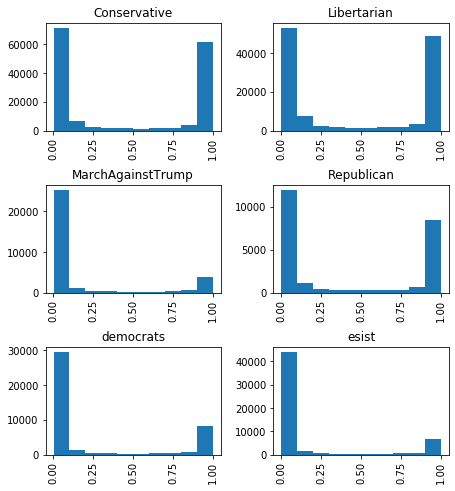

In [27]:
politics_all_post = pd.read_csv('topic_data\politics_cleanedpost.csv')
with open('topic_data\ALL_politics_predictions.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
politics_all_post['pred_label'] = pred_label
politics_all_post['pred_prob'] = prob_pred
politics_all_post.to_csv('topic_data\politics_cleanedpost_pred.csv', index=False)
politics_all_post['pred_prob'].hist(by=politics_all_post['subreddit'], figsize=(7,8))
plt.savefig('topic_data\graphs\politics_predxsubreddit.png')
plt.show()

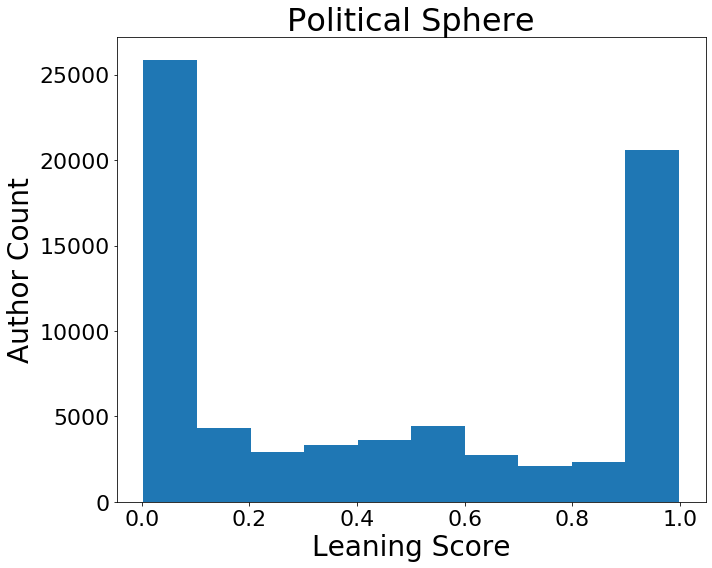

In [28]:
politic_user = pd.DataFrame({'prob_leaning' : politics_all_post.groupby( [ "author"] )['pred_prob'].mean()}).reset_index()
plt.figure(figsize=(10,8))
politic_user['prob_leaning'].hist(grid=False)
plt.xlabel('Leaning Score', size=28)
plt.ylabel('Author Count', size=28)
plt.title('Political Sphere', size=32)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tight_layout()
plt.savefig('topic_data\graphs\politics_user_pred.png')

## Gun Control

In [29]:
with open('topic_data\guncontrol_rawpost.pickle', "rb") as input_file:
     gun_all = pickle.load(input_file)
gun_all = gun_all.loc[gun_all.author != '[deleted]']
gun_all = gun_all.loc[gun_all.author != 'AutoModerator']
gun_all['clean_text'] = gun_all['title']+' '+gun_all['selftext']
submissions = gun_all.clean_text.values.tolist()
submissions = DataCleaning(submissions, 'BERT')
gun_all['clean_text'] = submissions
gun_all['post_id'] = 't3_'+gun_all['id'] # adding 't3_' symbol to retrieve post' comments (i.e., Reddit standard for post identification)
gun_all['date'] = pd.to_datetime(gun_all['created_utc'], unit='s') # transform unixtime stamp in a readable format
gun_all['date'] = gun_all['date'].dt.date
gun_all = gun_all.drop(['selftext', 'title', 'over_18', 'stickied'], axis=1)
gun_all.to_csv('topic_data\guncontrol_cleanedpost.csv')

In [30]:
# selecting only post written by ground truth users to make validation
gun_validation = gun_all.loc[gun_all.author.isin(list(BERT_authors_leaning.keys()))]
print('# validation post', len(gun_validation))
gun_validation['label'] = gun_validation.apply(lambda row: BERT_authors_leaning[row.author], axis=1)
n_users = gun_validation.groupby(['author']).count()
# stats
print('n_users', len(n_users))
print('# pro trump and anti trump posts')
print(gun_validation['label'].value_counts())
#print(gun_validation.groupby(['subreddit','label'])['label'].count())

# validation post 6093
ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
n_users 787
# pro trump and anti trump posts
0    4055
1    2038
Name: label, dtype: int64


In [31]:
# balancing guncontrol test set among the two class
gun_validation_left = gun_validation.loc[gun_validation.label == 0].sample(2100)
gun_validation_right = gun_validation.loc[gun_validation.label == 1]
gun_validation = gun_validation_left.append(gun_validation_right, ignore_index=True)

### BERT

In [32]:
gun_validation.to_csv('topic_data\guncontrol_validation.csv')
with open('topic_data\guncontrol_predictions_val.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions[0]
true_label = predictions[1]
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[1811  581]
 [ 501  889]]
Accuracy Score : 0.7139079851930196
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      2392
         1.0       0.60      0.64      0.62      1390

    accuracy                           0.71      3782
   macro avg       0.69      0.70      0.70      3782
weighted avg       0.72      0.71      0.72      3782



### LSTM

In [33]:
from LSTM_predict import LSTModel

file_model = 'Model Selection\Models\LSTM\LSTM_model_glove.json'
file_weights = 'Model Selection\Models\LSTM\LSTM_model_glove.h5'
file_tokenizer = 'Model Selection\Models\LSTM\LSTM_tokenizer_def.pickle'
model = LSTModel(file_model, file_weights, file_tokenizer)
pred_prob = model.predict_prob(gun_validation['clean_text'])
pred_label = model.predict_class(gun_validation['clean_text']) 
true_label = gun_validation['label'] 
# computing performances
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[1354  746]
 [ 718 1320]]
Accuracy Score : 0.6462058965683906
Classification Report : 
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2100
           1       0.64      0.65      0.64      2038

    accuracy                           0.65      4138
   macro avg       0.65      0.65      0.65      4138
weighted avg       0.65      0.65      0.65      4138



### Predict political polarization degree of all GunControl post

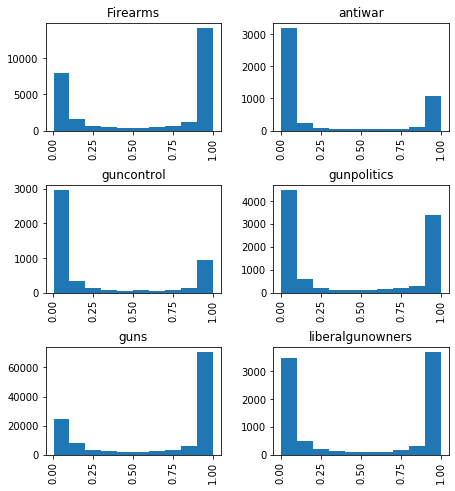

In [34]:
gun_all_post = pd.read_csv('topic_data\guncontrol_cleanedpost.csv')
with open('topic_data\ALL_guncontrol_predictions.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
gun_all_post['pred_label'] = pred_label
gun_all_post['pred_prob'] = prob_pred
gun_all_post.to_csv('topic_data\guncontrol_cleanedpost_pred.csv', index=False)
gun_all_post['pred_prob'].hist(by=gun_all_post['subreddit'], figsize=(7,8))
plt.savefig('topic_data\graphs\guncontrol_predxsubreddit.png')
plt.show()

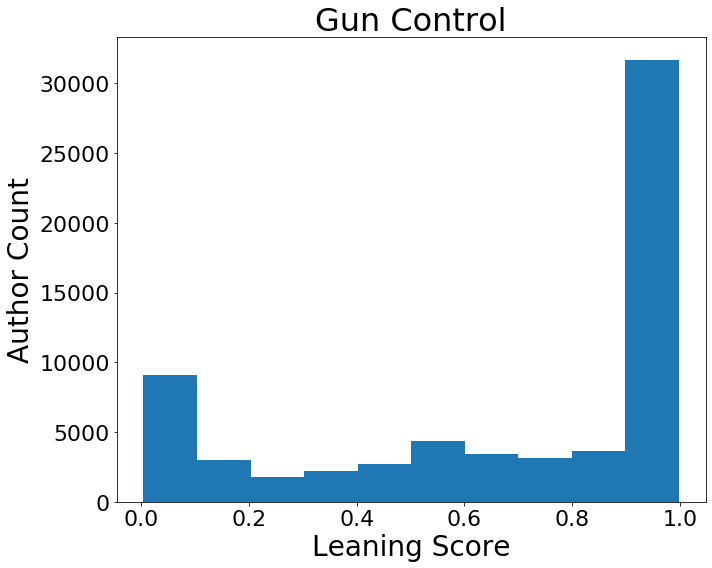

In [35]:
gun_user = pd.DataFrame({'prob_leaning' : gun_all_post.groupby( [ "author"] )['pred_prob'].mean()}).reset_index()
plt.figure(figsize=(10,8))
gun_user['prob_leaning'].hist(grid=False)
plt.xlabel('Leaning Score', size=28)
plt.ylabel('Author Count', size=28)
plt.title('Gun Control', size=32)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tight_layout()
plt.savefig('topic_data\graphs\gun_user_pred.png')

In [36]:
# merging guncontrol, minority and politics author distribution together
import matplotlib.pyplot as plt 
import matplotlib.image
img1 = matplotlib.image.imread('topic_data\graphs\gun_user_pred.png')
img2 = matplotlib.image.imread('topic_data\graphs\minority_user_pred.png')
img3 = matplotlib.image.imread('topic_data\graphs\politics_user_pred.png')
row3 = np.concatenate((img1, img2, img3), axis=1)
matplotlib.image.imsave('topic_data\graphs\topic_polarization.png', row3)

## Splitting each topic in five semester 

In [37]:
minority = pd.read_csv('topic_data\minority_cleanedpost.csv')
politics = pd.read_csv('topic_data\politics_cleanedpost.csv')
guncontrol = pd.read_csv('topic_data\guncontrol_cleanedpost.csv')

### datasets statistics

In [38]:
print('gun control')
print('# subreddits', len(guncontrol['subreddit'].unique()))
print('# post:', len(guncontrol))
print('# user', len(guncontrol['author'].unique()))
print('minority')
print('# subreddits', len(minority['subreddit'].unique()))
print('# post:', len(minority))
print('# user', len(minority['author'].unique()))
print('politics')
print('# subreddits', len(politics['subreddit'].unique()))
print('# post:', len(politics))
print('# user', len(politics['author'].unique()))

gun control
# subreddits 6
# post: 180170
# user 65111
minority
# subreddits 6
# post: 223096
# user 52337
politics
# subreddits 6
# post: 431930
# user 72399


In [39]:
# defining, for each category and semester, a dict with postd_id as key and post author as value
periods = [('2017-01-01','2017-07-01'),('2017-07-01','2018-01-01'),('2018-01-01','2018-07-01'),('2018-07-01','2019-01-01'),('2019-01-01','2019-07-01')] #semesters
topics = [minority, guncontrol, politics]
path = 'topic_data\semester_2kpost'
topics_names = ['minority','guncontrol','politics']
for topic, topic_name in zip(topics, topics_names):
    for period in periods:
        id_author = dict() 
        df = topic.loc[(topic.date >= period[0]) & (topic.date <= period[1])]
        df = df.loc[df.num_comments > 5]
        subreddits = df['subreddit'].unique()
        selected = pd.DataFrame()
        for sub in subreddits:
            sub_df = df.loc[df.subreddit == sub]
            try:
                sub_df = sub_df.sample(400)
            except:
                sub_df = sub_df
            selected = selected.append(sub_df, ignore_index=True)
        for index, row in selected.iterrows():
            id_author[row['post_id']] = row['author']
        semester_path = os.path.join(path, f'{topic_name}_{period[0]}_{period[1]}.pickle')                           
        with open(semester_path, "wb") as output_file: # for each topic and semester dict with post_id as key and author name as value (for retrieving post' comments)
            pickle.dump(id_author, output_file)

In [40]:
# defining, for each category and semester, a csv file with (author, mean_polarization_score, label)
path = 'topic_data\semester_2kpost'
files = os.listdir(path)
path_df = 'topic_data'
final_path = 'topic_data\Categories_networks'
for topic in files:
    topic_name = topic.split('_')[0]
    semester_start = topic.split('_')[1]
    semester_end = topic.split('_')[2].replace('.pickle','')
    with open(f'{path}\{topic}', "rb") as input_file:
        post_ids_authors = pickle.load(input_file) # loading dict with post_id as key and author name as value
    authors_list = set(post_ids_authors.values())
    df = pd.read_csv(f'{path_df}\{topic_name}_cleanedpost_pred.csv')
    filtered = df.loc[(df.author.isin(authors_list)) & (df.date >= semester_start) & (df.date <= semester_end)]
    authors_list =  filtered.groupby('author')['pred_prob'].count().index.get_level_values(0).tolist()
    mean_score_authors = filtered.groupby('author')['pred_prob'].mean().tolist()
    athors_labels = ['protrump' if v >= 0.7 else 'antitrump' if v <= 0.3 else 'neutral' for v in mean_score_authors]
    df_authors_score = pd.DataFrame(
        {'author': authors_list,
        'mean_score': mean_score_authors,
        'leaning': athors_labels
        })
    df_authors_score.to_csv(f'{final_path}\{topic_name}\{topic_name}_{semester_start}_{semester_end}_labels.csv', index=False)